In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader

from model_harness import ModelHarness
import utils


c:\Users\karen\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Load and prepare data

In [2]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Get train and test data

In [3]:
x = df.iloc[:, 1:5].values
y = df['Species'].values
le = LabelEncoder()
y = le.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=1./3., 
                                                    random_state=42)

Normalize data and prepare Torch dataset

In [4]:
normalize = utils.Normalize()
x_train = torch.from_numpy(normalize.fit_transform(x_train)).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(normalize.transform(x_test)).float()
y_test = torch.from_numpy(y_test).long()

torch.manual_seed(42)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, 2, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, 2, shuffle=False)


## Define the model

In [5]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.layer2 = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.softmax(x)
        return x 

model = Model(x_train.shape[1], 16, 3)

""" model = torch.nn.Sequential(
    torch.nn.Linear(x_train.shape[1], 16),
    torch.nn.Sigmoid(),
    torch.nn.Linear(16, 3),
    torch.nn.Softmax(dim=1)
) """

trainer = ModelHarness(model,
                       torch.nn.CrossEntropyLoss(),
                       torch.optim.Adam,
                       learning_rate = 0.001)

model

Device = cpu


Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (layer2): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## Try it out!

In [6]:
hist = trainer.train(train_dl, 50)


Epoch 1
50/50[====================] 0.0690 sec - Loss: 1.1023 - Accuracy: 31.00%
Epoch 2
50/50[====================] 0.0500 sec - Loss: 1.0914 - Accuracy: 31.00%
Epoch 3
50/50[====================] 0.0490 sec - Loss: 1.0822 - Accuracy: 31.00%
Epoch 4
50/50[====================] 0.0540 sec - Loss: 1.0732 - Accuracy: 42.00%
Epoch 5
50/50[====================] 0.0720 sec - Loss: 1.0654 - Accuracy: 48.00%
Epoch 6
50/50[====================] 0.0480 sec - Loss: 1.0563 - Accuracy: 63.00%
Epoch 7
50/50[====================] 0.0450 sec - Loss: 1.0470 - Accuracy: 68.00%
Epoch 8
50/50[====================] 0.0440 sec - Loss: 1.0343 - Accuracy: 65.00%
Epoch 9
50/50[====================] 0.0520 sec - Loss: 1.0213 - Accuracy: 65.00%
Epoch 10
50/50[====================] 0.0460 sec - Loss: 1.0061 - Accuracy: 67.00%
Epoch 11
50/50[====================] 0.0440 sec - Loss: 0.9906 - Accuracy: 65.00%
Epoch 12
50/50[====================] 0.0440 sec - Loss: 0.9727 - Accuracy: 65.00%
Epoch 13
50/50[==========

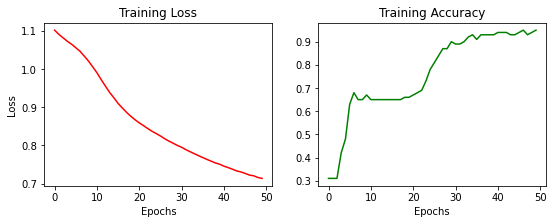

In [7]:
utils.plot_history(hist)

Evaluate the model

In [8]:
preds, labels, _ = trainer.evaluate(test_dl)


25/25[====================] 0.0070 sec - Accuracy 98.00%


In [9]:
confusion_matrix(y_test, labels)

array([[19,  0,  0],
       [ 0, 14,  1],
       [ 0,  0, 16]], dtype=int64)